First we'll import all the tools we need.

In [1]:
import numpy as np
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
import os

from keras.models import Sequential, Model
from keras.layers import Dense, Input, Reshape, Dropout
from keras.layers.core import Activation, Flatten
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import Conv2D, MaxPooling2D, UpSampling2D
from keras.layers.advanced_activations import LeakyReLU
from keras.callbacks import EarlyStopping
from keras.optimizers import SGD, Adam
from keras.datasets import mnist
from keras.utils import np_utils
from keras.initializers import RandomNormal

C:\ProgramData\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


Next we'll download the MNIST data set, in lieu of anything more interesting to work with. Note the MNIST sets consist of 28x28 images. This is going to be inconvenient later - we'd really like to work with images whose dimensions are powers of 2 as it makes for a more elegant construction of the generator, so let's pad them out to be 32x32 images.

We'll also define a function for plotting MNIST-type images so that we can see the output of the generator.

(60000, 32, 32, 1)
(10000, 32, 32, 1)


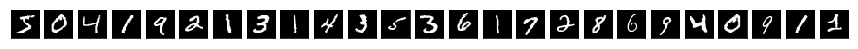

In [2]:
from keras.datasets import mnist

(x_train, _), (x_test, _) = mnist.load_data()

x_train = x_train.astype('float32') / 127.5 - 1
x_test = x_test.astype('float32') / 127.5 -1

x_train = np.pad(x_train, ((0,0),(2,2),(2,2)), 'minimum')
x_test = np.pad(x_test, ((0,0),(2,2),(2,2)), 'minimum')

x_train = np.reshape(x_train, (len(x_train), 32, 32, 1))  # adapt this if using `channels_first` image data format
x_test = np.reshape(x_test, (len(x_test), 32, 32, 1))  # adapt this if using `channels_first` image data format

print(x_train.shape)
print(x_test.shape)

def plotImages(images, n = 25):
  plt.figure(figsize=(15, 15))
  for i in range(n):
    ax = plt.subplot(2, n, i + 1)
    plt.imshow((images[i].reshape(32, 32) + 1) / 2)
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
  plt.show()
  
plotImages(x_train)

Here's a function to define the generator layer. We want to upsample to a 32x32 image, with a convolutional layer at each upsampling. Each upsampling with a 2x2 shape doubles the size of the image, so we can start with with a 2x2 image with a large number of features and upsample 5 times to get to 32x32. 

If we'd kept the original 28x28 images, we'd have to start with a dimension of 7 and upsample twice to get to 28 (= 7 x 2 x 2), giving us fewer convolutional layers.


In [3]:
def generator(inputLayer, initialFeatures = 128, outputDim = 32, outputFeatures = 1):
  # Here we find the number of times the output dimension is divisible by 2
  for loop in range(int(np.log2(outputDim)) + 1):
    if(outputDim % np.power(2, loop) != 0):
      break
  # Given the number of times the output dimension is divisible by 2,
  # we can determine the initial dimension of the dense layer from a random vector.
  initialDim = outputDim // np.power(2, loop - 1)
  if initialDim == outputDim:
    raise ValueError("The outputDim is not divisible by 2 - there's no clean way to upsample.")
     
  x = Dense(initialDim*initialDim*initialFeatures, activation = 'relu', kernel_initializer='random_normal')(inputLayer)
  x = Reshape((initialDim, initialDim, initialFeatures))(x)
  
  # Now we can repeatedly upsample doubling the dimension each time 
  # and convolute, halving the number of features
  # until we arrive at (half the) right output dimension
  for ii in range(loop - 1):
    x = UpSampling2D(size=(2, 2))(x)
    x = Conv2D(initialFeatures // np.power(2, ii), kernel_size = 3, padding ='same')(x)
    x = BatchNormalization(momentum = 0.5)(x)
    x = LeakyReLU(0.2)(x)
  # now reduce the features to one (for MNIST) - for colour images we may need three or more channels in output
  x = Conv2D(outputFeatures, kernel_size = 3, padding ='same', activation = "tanh")(x)
  return x
  
inputRandom = Input(shape=(100,))  # adapt this if using `channels_first` image data format

genImage = generator(inputRandom, outputDim = 32)
  
print(genImage)

Tensor("conv2d_5/Tanh:0", shape=(?, 32, 32, 1), dtype=float32)


And here's a function to define a discriminator layer. In the original DCGAN paper, this is envisaged as an almost direct mirror image of the generator. It need not be - we could have fewer layers (to make the discriminator less efficient) as long as we end with a dense layer mapping to a single output.

For both generator and discriminator, batch normalisation is crucial to getting any kind of useful result - but I don't understand why. My guess is that without batch normalisation, the interactions of discriminator/generator tend to get into a feedback loop that drives the generator to extremes, but I don't know this for certain.

In [4]:
def discriminator(inputImage, initialFeatures= 32, numLayers = 4):
  x = inputImage
  for ii in range(numLayers):
    x = Conv2D(initialFeatures * np.power(2, ii), kernel_size = 3, padding='same', strides=(2,2), kernel_initializer='random_normal')(x)
    if ii > 0: x = BatchNormalization(momentum = 0.5)(x)
    x = LeakyReLU(0.2)(x)
    x = Dropout(0.25)(x)
  x = Flatten()(x)
  x = Dense(1, activation = 'sigmoid')(x)
  return x

inputImage = Input(shape=(32, 32, 1))  # adapt this if using `channels_first` image data format

discImage = discriminator(inputImage)

print(discImage)

Tensor("dense_2/Sigmoid:0", shape=(?, 1), dtype=float32)


Now comes the conceptually tricky bit. The best way I've found to think about this is found on ctmakro's github page:
![GAN training architecture](https://ctmakro.github.io/site/on_learning/fast_gan_in_keras_graph_1.svg)

This map of the model makes it clear what we're trying to do in each training pass. We generate a random input 'z' which we feed into the generator along with the weights 'Wg' (the generator's weights, which we want to train). That produces a set of generated images, which we feed into a copy of the discriminator. 

The generator's performance ('G_loss') is measured on its ability to get the discriminator to regard the generated images as true positives - what the discriminator says about the input images is irrelevant to the generator's loss. Then we update (green arrow) the generator's weights based on the generator's loss.

The discriminator's performance ('D_loss') is measured on its ability to separate the generated images (the output of 'D(copy1)'') from the true images (the output of 'D(copy2)'). We update (blue arrow) the discriminator's weights based on the discriminator's loss.

In native Keras, we don't have a way to update one set of weights 'Wg' based on the 'G_loss' and another set of weights 'Wd' based on the 'D_loss' and so we have to split this update process. 

In each training step, we first produce a set of generated images to feed into the discriminator (along with the true images) and train the discriminator's loss. Then we freeze the discriminator's weights (make it untrainable) and train the generator by feeding the generated images into the discriminator, with the generator being scored on how strongly the discriminator predicts that the generated images are true.

[ctmakro's github - Fast DCGAN in Keras](https://ctmakro.github.io/site/on_learning/fast_gan_in_keras.html) has a method for rewriting the necessary update steps in tensorflow, making it possible to update both sets of weights in one step, making for a faster update process. For the moment, we'll stick with the longer method as this tends to be the one that gets implemented (but often not explained)

Here we can build the models. We need a discriminator model that can be trained on true/fake images, a generator model that will be used to create fake images, and a combined model that will link the generator to the discriminator to produce the loss on the generator. 

Since the loss on the generator is measured by assuming the fake images are real, we need to freeze (set untrainable) the discriminator model so as not to disrupt the training of the discriminator by feeding it false information.

I'm wrapping the whole thing up in a function so that we can easily generate fresh models for use with a tweaked training regime.

In [5]:
optimizer = Adam(0.0002, 0.5)

def dcganModels():
  discModel = Model(inputImage, discImage)
  discModel.trainable = True
  discModel.compile(loss = 'binary_crossentropy', optimizer = optimizer, metrics=['accuracy'])
  
  genModel = Model(inputRandom, genImage)
  genModel.compile(loss = 'binary_crossentropy', optimizer = optimizer)

  discModel.trainable = False
  discOnGen = discModel(genImage)
  combinedModel = Model(inputRandom, discOnGen)
  combinedModel.compile(loss = 'binary_crossentropy', optimizer = optimizer, metrics=['accuracy'])
  return(combinedModel, discModel, genModel)

Now we can train the models. We first generate the fake images, then train the discriminator on these and an equal sized random batch of the true images. Then we train the generator. Every four hundred epochs, we'll take a look at a sample of the current output.

C:\ProgramData\Anaconda3\lib\site-packages\keras\engine\training.py:975: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


Generator Loss: [2.2735064, 0.0625] Discriminator Loss: [0.3817553 0.8125   ]


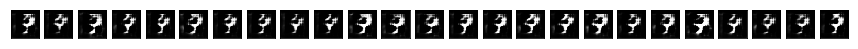

Generator Loss: [2.21341, 0.03125] Discriminator Loss: [0.2535743 0.953125 ]


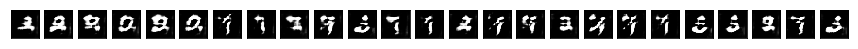

Generator Loss: [1.8704735, 0.03125] Discriminator Loss: [0.44431853 0.78125   ]


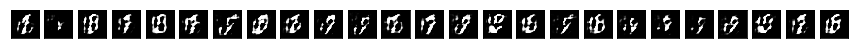

Generator Loss: [1.9641774, 0.09375] Discriminator Loss: [0.36611712 0.84375   ]


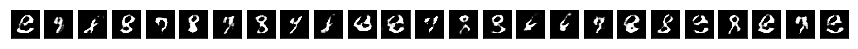

Generator Loss: [1.9794486, 0.03125] Discriminator Loss: [0.24776748 0.890625  ]


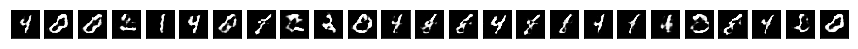

In [6]:
combinedModel, discModel, genModel = dcganModels()

batchSize = 32

valid = np.ones(batchSize)
fake = np.zeros(batchSize)

for i in range(2500):
  trueImages = x_train[np.random.randint(0, x_train.shape[0], batchSize),]
  randomInput = np.random.normal(0, 1, (batchSize,100))
  generatedImages = genModel.predict(randomInput)
  discLoss = 0.5 *  np.add(discModel.train_on_batch(trueImages, valid), discModel.train_on_batch(generatedImages, fake))
  genLoss = combinedModel.train_on_batch(randomInput, valid)
  
  if (i + 1) % 500 == 0:
    print('Generator Loss:', genLoss, 'Discriminator Loss:', discLoss)
    plotImages(genModel.predict(randomInput))

One trick for improving performance of GANs is to add random noise to both the true and fake images as they go into the discriminator. This weakens the discriminator by creating more overlap between (the distribution of) true and fake images (http://www.inference.vc/instance-noise-a-trick-for-stabilising-gan-training/). As the generator improves, we require less noise to confuse the discriminator, and so we can weaken the amount of noise being added over time. This seems to offer considerably faster training, and more convincing output.

C:\ProgramData\Anaconda3\lib\site-packages\keras\engine\training.py:975: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


Generator Loss: [0.92232335, 0.375] Discriminator Loss: [0.5866759 0.640625 ] Gen Eval: [0.5466575622558594, 1.0]


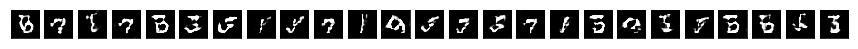

Generator Loss: [1.1199439, 0.40625] Discriminator Loss: [0.5673721 0.671875 ] Gen Eval: [0.5908396244049072, 1.0]


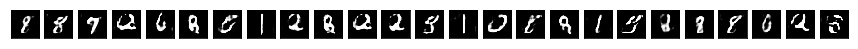

Generator Loss: [1.6402631, 0.0625] Discriminator Loss: [0.47423792 0.75      ] Gen Eval: [0.458994597196579, 1.0]


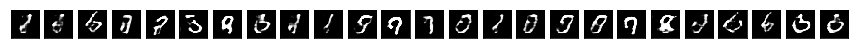

Generator Loss: [1.9639516, 0.03125] Discriminator Loss: [0.37669298 0.875     ] Gen Eval: [0.44270896911621094, 1.0]


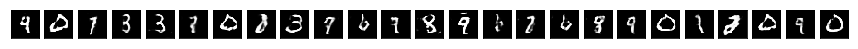

In [ ]:
combinedModel, discModel, genModel = dcganModels()

batchSize = 32

valid = np.ones(batchSize)
fake = np.zeros(batchSize)

for i in range(2500):
  noise_factor = np.clip(1 - i/(2000 - 1), 0, 1)
  trueImages = x_train[np.random.randint(0, x_train.shape[0], batchSize),]
  trueImages = trueImages + np.random.normal(loc=0.0, scale=noise_factor, size=trueImages.shape)
  trueImages = np.clip(trueImages, -1, 1)
  randomInput = np.random.normal(0, 1, (batchSize,100))
  generatedImages = genModel.predict(randomInput)
  generatedImages = generatedImages + np.random.normal(loc=0.0, scale=noise_factor, size=generatedImages.shape)
  generatedImages = np.clip(generatedImages, -1, 1)
  discLoss = 0.5 *  np.add(discModel.train_on_batch(trueImages, valid), discModel.train_on_batch(generatedImages, fake))
  genLoss = combinedModel.train_on_batch(randomInput, valid)
  
  if (i + 1) % 500 == 0:
    val = combinedModel.evaluate(randomInput, valid, batch_size = batchSize, verbose = False)
    print('Generator Loss:', genLoss, 'Discriminator Loss:', discLoss, 'Gen Eval:', val)
    plotImages(genModel.predict(randomInput))

This is as far as I've got. There's some more extensions I'd like to try:


* Implementing the 'ctmakro' method for training generator and discriminator simultaneously seems like an obvious next step
* I think it would be interesting to make the generator act as the second half of an autoencoder as well as a generator.
* The super-resolution GANs (http://blog.otoro.net/2016/04/01/generating-large-images-from-latent-vectors/) seem very cool.

It would be nice to have a more interesting dataset, but I'm not going to invest a lot of time searching for one at the moment. If anybody wants to provide one, that's great.

The main questions I still have about the basic GAN model:


*   Why is batchNormalization so important? I get pretty much instant and irreversible model failure if I remove it.
*   As a secondary question; note that in the last fit I run .evaluate on the generator model and get substantially different metrics to those when I'm fitting ('Gen Eval' compared to 'Generator Loss'). Ok, this is due to batchNormalisation being applied differently in training & test modes in Keras. But the '.predict' method runs in test mode, and that's providing the input to the discriminator. Would we get better results if we could run all the training steps in training mode, and how can this be implemented in Keras?
* Why is it important to train the discriminator twice in each epoch (once on true, once on fake)? I've seen this reported in a number of places, and the model does not do well if you merge the trainings - but I don't know why. I suspect batchNormalization again - the distribution of the data will presumably be very different between the true and fake images. Similarly, training the generator after training the discriminator in each epoch seems pretty essential to getting good results, but I don't know why.

Any thoughts?

